In [22]:
import os
from pathlib import Path
import IPython.display as ipd
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
from IPython import display
import time
from datetime import datetime, timedelta
import tensorflow as tf
import seaborn as sns
import subprocess
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

# NOTES
NOTES = "28x28"

# VARS
INPUT_CSV = "arm_01_04"
CATEGORY = ["no_voice"]
ALL_LABELS = ['zero', 'one', 'two', 'three', 'four', 
            'five', 'six', 'seven', 'eight', 'nine',
            'left', 'right', 'stop', 'go', 'up', 
            'down', 'oneFinger', 'twoFinger']
LABELS = ALL_LABELS[:] # choose labels to train on
CHANNELS = [1,2]
NUMS = ''.join([str(x) for x in CHANNELS])
MONTHS = list(range(1,13))
DAYS = list(range(1,32))

target_label = "Label"
id_label = "fname"
OUTSTR = "A{:.4f}_Type{}_UDR{}_THRESH{:5.3f}_DROP{}_LR{}_S{}_B{}{}.csv"
IMG_EXT = ".png"
VERBOSE = True
DISPLAY = True
TEST = False
MFCC = False
TPU = False
RESIZE = True
INPUT_WIDTH = 128
INPUT_HEIGHT = 128
TARGET_WIDTH = 28 if RESIZE else INPUT_WIDTH
TARGET_HEIGHT = 28 if RESIZE else INPUT_HEIGHT
DECAY_RATE = 0.9
IMG_CHANNELS = 3
DROPOUT = 0.4
TYPE = "CNN"
DEFAULT_BS = 128 # default batch size
UNK_DROP_RATE = 1.0 # drop 100% of unknown categories

if TEST:
    LEARNING_STEPS = 100
    SPP = 4
    LEARNING_RATE = .05
    BATCH_SIZE = 32
    VERBOSITY = 1000
    TEST_SIZE = 1000
    SHUFFLE_SIZE = 64
else:
    LEARNING_STEPS = 10000
    SPP = 200
    LEARNING_RATE = .025 # 0.025 for 2 labels
    BATCH_SIZE = 64
    VERBOSITY = 1000
    SHUFFLE_SIZE = 256

def curr_time():
    return datetime.now() - timedelta(hours=7) # offset from UTC to PST

ROOT = os.getcwd() + "/"
if CATEGORY[0] == "no_voice":
    RUN_ROOT = ROOT+"models/"+"NONVOCAL_RUNS_YN_{:02}_{:02}/".format(MONTHS[0], DAYS[0])
else:
    RUN_ROOT = ROOT + "models/" + "VOCAL_RUNS_YN_{:02}_{:02}/".format(MONTHS[0], DAYS[0])
RUN_ROOT_LOG = RUN_ROOT + "logs/"

# PATHS
paths = {
    "Training":ROOT + "train_csv/" + INPUT_CSV + ".csv",
    "Model":RUN_ROOT+"model_dir_{}/".format(NUMS),
    "Logs":RUN_ROOT_LOG+"{}_{}/".format(NUMS, datetime.strftime(curr_time(), "%b%d%Y_%H%M%S"))
}
paths["Log"] = paths["Logs"] + "log.txt"
if not os.path.isdir(RUN_ROOT):
    os.mkdir(RUN_ROOT)
if not os.path.isdir(RUN_ROOT_LOG):
    os.mkdir(RUN_ROOT_LOG)
if not os.path.isdir(paths["Logs"]):
    os.mkdir(paths["Logs"])

In [23]:
def make_header(s):
    return ("#" * 42) + ("\n{:^42}\n".format(s)) + ("#" * 42)
    
def print_and_log(s):
    with open(paths["Log"], 'a') as log:
        log.write(str(s))
        log.write("\n")
    print(s)
        
def print_and_log_header(s):
    h = make_header(str(s))
    with open(paths["Log"], 'a') as log:
        log.write(h)
        log.write("\n")
    print(h)

In [24]:
def sec_to_str(secs):
    ms = secs - int(secs)
    days = int(secs // (24 * 3600))
    hours = int((secs % ((24 * 3600))) // 3600)
    minutes = int((secs % 3600) // 60)
    seconds = int(secs % 60)
    return "{:02}:{:02}:{:02}:{:02}.{}".format(days, hours, minutes, seconds, "{:.3}".format(ms)[2:])

def timer(f, *args):
    print_and_log("Start: {}".format(curr_time()))
    start = time.time()
    result = f(*args)
    end = time.time()
    print_and_log("End: {}".format(curr_time()))
    print_and_log("Finished in {}".format(sec_to_str(end - start)))
    return result

def preprocess(samples, sample_rate):
    padded = np.zeros(sample_rate)
    samples = samples[:sample_rate]
    padded[:samples.shape[0]] = samples
    return padded

def select_labels(df, allowed):
    return df[df['Label'].isin(allowed)]
    
def select_categories(df, allowed):
    return df[df['Category'].isin(allowed)]

def select_channels(df, allowed):
    labels = []
    for i in range(1, 9):
        if i not in allowed:
            labels.append("Path{}".format(i))
    return df.drop(labels, axis=1)

def select_days(df, allowed):
    return df[df['Day'].isin(allowed)]

def select_months(df, allowed):
    return df[df['Month'].isin(allowed)]

def select_sets(df, allowed):
    return df[df['Set'].isin(allowed)]

def remove_voice(df):
    return df.drop(["Path4"], axis=1)

def str_to_l(x):
    return [int(n) for n in x if n <= '9' and n >= '0']

In [25]:
count = 0
def _parse_function(label, *filenames):
    global count
    count += 1
    if count % VERBOSITY == 0:
        print_and_log("\tProcessed {}th image".format(count))
    expected_shape = tf.constant([1, INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS])
    image = None
    for filename in filenames:
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_image(image_string, channels=IMG_CHANNELS)
        image_decoded = tf.image.convert_image_dtype(image_decoded, tf.float32)
        image_decoded = tf.reshape(image_decoded, expected_shape)
        image_decoded = tf.image.rgb_to_grayscale(image_decoded)
        if RESIZE:
            image_decoded = tf.image.resize_bicubic(image_decoded, [TARGET_HEIGHT, TARGET_WIDTH])
        if image is not None:
            image = tf.concat([image, image_decoded], 3)
        else:
            image = image_decoded
    return image, label

In [26]:
def model_fn(features, labels, mode):
    input_layer = tf.reshape(features, [-1, TARGET_HEIGHT, TARGET_WIDTH, len(CHANNELS)])
    pool = input_layer

    for num_filters in [32, 64]:
        conv = tf.layers.conv2d(
            inputs=pool,
            filters=num_filters,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool = tf.layers.flatten(pool)
    dense = tf.layers.dense(inputs=pool, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=DROPOUT, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=num_labels)
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if not TPU:
        tf.summary.histogram("predictions", predictions["probabilities"])
        tf.summary.histogram("classes", predictions["classes"])

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    learning_rate = tf.train.exponential_decay(LEARNING_RATE, tf.train.get_global_step(), SPP, DECAY_RATE, staircase=True)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        if TPU:
            optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [27]:
def create_training_input_fn(dataset, batch_size, num_epochs=None):
    def _input_fn(num_epochs=None, shuffle=True):
        ds = dataset.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(SHUFFLE_SIZE)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def create_predict_input_fn(dataset, batch_size):
    def _input_fn():
        ds = dataset.batch(batch_size)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def train_helper(steps_per_period):
    classifier.train(
        input_fn=train_input_fn,
        steps=steps_per_period)
    training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
    validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
    t_ll = training_stats["loss"]
    t_acc = 100 * training_stats["accuracy"]
    v_ll = validation_stats["loss"]
    v_acc = 100 * validation_stats["accuracy"]
    return classifier, t_ll, v_ll, t_acc, v_acc

def train():
    periods = LEARNING_STEPS // SPP
    steps_per_period = LEARNING_STEPS // periods
    t_accs, v_accs = [], []
    t_lls, v_lls = [], []
    print_and_log("Training model...\nMetrics:")
    print_and_log("\tPERIOD\tRATE\tTYPE\tTRAIN.\tVALID.\tTIME")
    for period in range(periods):
        lr = LEARNING_RATE * (DECAY_RATE ** ((period * SPP) / SPP))
        classifier, t_ll, v_ll, t_acc, v_acc = train_helper(steps_per_period)
        print_and_log("\t{}\t{:.5f}\tLgLs\t{:.2f}\t{:.2f}\t{}".format(period, lr, t_ll, v_ll, curr_time()))
        print_and_log("\t\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
        t_lls.append(t_ll)
        v_lls.append(v_ll)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
    v_accuracy = v_accs[-1]
    return classifier, v_accuracy, t_lls, v_lls, t_accs, v_accs

In [28]:
with open(paths["Log"], 'w') as log:
    log.write(make_header("Starting Script\n"))

In [29]:
# Create variables for the paths
train_csv = paths["Training"]

# Store the labels to train
all_labels = LABELS
labels = LABELS
num_labels = len(labels)# - 1
labels = {x[1]:x[0] for x in enumerate(labels)}
reverse_lookup = {labels[k]:k for k in labels}

In [30]:
print(reverse_lookup)

{0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10: 'left', 11: 'right', 12: 'stop', 13: 'go', 14: 'up', 15: 'down', 16: 'oneFinger', 17: 'twoFinger'}


In [31]:
# Make the training data
print_and_log_header("MAKING TRAINING DATA")
train_data = pd.read_csv(train_csv)

# Filter the training data
train_data = select_categories(train_data, CATEGORY)
#train_data = select_channels(train_data, CHANNELS)
train_data = select_labels(train_data, all_labels)
train_data = select_months(train_data, MONTHS)
train_data = select_days(train_data, DAYS)
# train_data = remove_voice(train_data)

train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data["Label"] = train_data["Label"].map(labels)

if VERBOSE:
    print_and_log_header("TRAIN DATA")
    print_and_log(train_data.describe())
    print_and_log(train_data.head(10))

##########################################
           MAKING TRAINING DATA           
##########################################
##########################################
                TRAIN DATA                
##########################################
         Day  Month       Label  SequenceNumber  Path2  Path3  Path4
count  202.0  202.0  202.000000      202.000000    0.0    0.0    0.0
mean     4.0    1.0   16.500000       50.000000    NaN    NaN    NaN
std      0.0    0.0    0.501242       29.227194    NaN    NaN    NaN
min      4.0    1.0   16.000000        0.000000    NaN    NaN    NaN
25%      4.0    1.0   16.000000       25.000000    NaN    NaN    NaN
50%      4.0    1.0   16.500000       50.000000    NaN    NaN    NaN
75%      4.0    1.0   17.000000       75.000000    NaN    NaN    NaN
max      4.0    1.0   17.000000      100.000000    NaN    NaN    NaN
   Category  Day  Month  Label  SequenceNumber         Set  \
0  no_voice    4      1     17               1    Training 

In [32]:
if VERBOSE:
    print_and_log(train_data.head(10))

   Category  Day  Month  Label  SequenceNumber         Set  \
0  no_voice    4      1     17               1    Training   
1  no_voice    4      1     16              80    Training   
2  no_voice    4      1     16              49     Testing   
3  no_voice    4      1     16              36    Training   
4  no_voice    4      1     16               1    Training   
5  no_voice    4      1     16               8  Validation   
6  no_voice    4      1     17              19     Testing   
7  no_voice    4      1     17              76    Training   
8  no_voice    4      1     16              68  Validation   
9  no_voice    4      1     16              28  Validation   

                                               Path1  Path2  Path3  Path4  
0  /Users/kyy/cerebro_train/images_scaled/arm_01_...    NaN    NaN    NaN  
1  /Users/kyy/cerebro_train/images_scaled/arm_01_...    NaN    NaN    NaN  
2  /Users/kyy/cerebro_train/images_scaled/arm_01_...    NaN    NaN    NaN  
3  /Users/kyy

In [33]:
# Grab subset of the data for testing purposes
if TEST:
    train_data = train_data[:TEST_SIZE]

In [34]:
# 80/10/10 training/validation/test split
validation_data = select_sets(train_data, ["Validation"])
test_data = select_sets(train_data, ["Testing"])
train_data = select_sets(train_data, ["Training"])

In [35]:
print(train_data)

     Category  Day  Month  Label  SequenceNumber       Set  \
0    no_voice    4      1     17               1  Training   
1    no_voice    4      1     16              80  Training   
3    no_voice    4      1     16              36  Training   
4    no_voice    4      1     16               1  Training   
7    no_voice    4      1     17              76  Training   
11   no_voice    4      1     16              40  Training   
13   no_voice    4      1     16              74  Training   
14   no_voice    4      1     17               2  Training   
15   no_voice    4      1     17              82  Training   
16   no_voice    4      1     16              76  Training   
17   no_voice    4      1     16               5  Training   
18   no_voice    4      1     17              90  Training   
20   no_voice    4      1     17              87  Training   
21   no_voice    4      1     16              51  Training   
23   no_voice    4      1     17              40  Training   
27   no_

In [36]:
ids = test_data["Path{}".format(CHANNELS[0])] # store the png filenames for output
if VERBOSE:
    print_and_log_header("IDS")
    print_and_log(ids.describe())
    print_and_log(ids.head(10))

##########################################
                   IDS                    
##########################################
count                                                    20
unique                                                   20
top       /Users/kyy/cerebro_train/images_scaled/arm_01_...
freq                                                      1
Name: Path1, dtype: object
2     /Users/kyy/cerebro_train/images_scaled/arm_01_...
6     /Users/kyy/cerebro_train/images_scaled/arm_01_...
10    /Users/kyy/cerebro_train/images_scaled/arm_01_...
12    /Users/kyy/cerebro_train/images_scaled/arm_01_...
19    /Users/kyy/cerebro_train/images_scaled/arm_01_...
22    /Users/kyy/cerebro_train/images_scaled/arm_01_...
26    /Users/kyy/cerebro_train/images_scaled/arm_01_...
36    /Users/kyy/cerebro_train/images_scaled/arm_01_...
40    /Users/kyy/cerebro_train/images_scaled/arm_01_...
42    /Users/kyy/cerebro_train/images_scaled/arm_01_...
Name: Path1, dtype: object


In [37]:
# Separate Labels
train_labels = train_data.pop(target_label)
validation_labels = validation_data.pop(target_label)
test_labels = test_data.pop(target_label)
img_paths = ["Path{}".format(channel) for channel in CHANNELS]
train_data = train_data[img_paths]
validation_data = validation_data[img_paths]
test_data = test_data[img_paths]

In [38]:
# Vectors of filenames.
t_f, v_f, s_f = [], [], []
for i in range(1, 1 + len(CHANNELS)):
    channel = CHANNELS[i-1]
    l = "Path{}".format(channel)
    t_f.append(tf.constant(train_data[l]))
    v_f.append(tf.constant(validation_data[l]))
    s_f.append(tf.constant(test_data[l]))

# `labels[i]` is the label for the image in `filenames[i]
# Vectors of labels
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
test_labels = tf.constant(test_labels)

# Make datasets from filenames and labels
train_data = tf.data.Dataset.from_tensor_slices((train_labels, *t_f))
validation_data = tf.data.Dataset.from_tensor_slices((validation_labels, *v_f))
test_data = tf.data.Dataset.from_tensor_slices((test_labels, *s_f))
print_and_log_header("Parsing Training Data")
train_data = timer(lambda: train_data.map(_parse_function))
print_and_log_header("Parsing Validation Data")
validation_data = timer(lambda: validation_data.map(_parse_function))
print_and_log_header("Parsing Testing Data")
test_data = timer(lambda: test_data.map(_parse_function))
print_and_log("\nDone!")

##########################################
          Parsing Training Data           
##########################################
Start: 2019-01-04 06:53:40.153417
End: 2019-01-04 06:53:40.229838
Finished in 00:00:00:00.0754
##########################################
         Parsing Validation Data          
##########################################
Start: 2019-01-04 06:53:40.234580
End: 2019-01-04 06:53:40.296430
Finished in 00:00:00:00.0606
##########################################
           Parsing Testing Data           
##########################################
Start: 2019-01-04 06:53:40.300729
End: 2019-01-04 06:53:40.359899
Finished in 00:00:00:00.0584

Done!


In [39]:
print_and_log_header("TRAINING")
print_and_log(train_data)
print_and_log(type(train_data))
print_and_log_header("VALIDATION")
print_and_log(validation_data)
print_and_log(type(validation_data))
print_and_log_header("TESTING")
print_and_log(test_data)
print_and_log(type(test_data))

##########################################
                 TRAINING                 
##########################################
<MapDataset shapes: ((1, 28, 28, 1), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                VALIDATION                
##########################################
<MapDataset shapes: ((1, 28, 28, 1), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                 TESTING                  
##########################################
<MapDataset shapes: ((1, 28, 28, 1), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [40]:
# Create the Estimator
if TPU:
    classifier = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        model_dir=paths["Model"],
        config=tf.contrib.tpu.RunConfig(),
        use_tpu=TPU)
else:
    classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir=paths["Model"])

In [41]:
# Create the input functions.
training_eval_input_fn = create_predict_input_fn(train_data, DEFAULT_BS)
validation_eval_input_fn = create_predict_input_fn(validation_data, DEFAULT_BS)
test_eval_input_fn = create_predict_input_fn(test_data, DEFAULT_BS)
train_input_fn = create_training_input_fn(train_data, BATCH_SIZE)

In [42]:
# Train
classifier, accuracy, t_lls, v_lls, t_accs, v_accs = timer(train)

Start: 2019-01-04 06:53:40.397809
Training model...
Metrics:
	PERIOD	RATE	TYPE	TRAIN.	VALID.	TIME
	0	0.02500	LgLs	0.70	0.70	2019-01-04 06:54:10.160564
			Acc.	50.00%	50.00%

	1	0.02250	LgLs	0.70	0.70	2019-01-04 06:54:39.432845
			Acc.	50.62%	50.00%

	2	0.02025	LgLs	0.69	0.70	2019-01-04 06:55:08.925819
			Acc.	50.00%	50.00%

	3	0.01823	LgLs	0.69	0.69	2019-01-04 06:55:37.700843
			Acc.	50.00%	50.00%

	4	0.01640	LgLs	0.70	0.70	2019-01-04 06:56:06.851720
			Acc.	50.62%	50.00%

	5	0.01476	LgLs	0.69	0.69	2019-01-04 06:56:35.933602
			Acc.	51.85%	50.00%

	6	0.01329	LgLs	0.69	0.69	2019-01-04 06:57:04.827925
			Acc.	51.85%	50.00%

	7	0.01196	LgLs	0.69	0.69	2019-01-04 06:57:33.675609
			Acc.	51.23%	50.00%

	8	0.01076	LgLs	0.69	0.69	2019-01-04 06:58:02.398695
			Acc.	56.17%	45.00%

	9	0.00969	LgLs	0.69	0.69	2019-01-04 06:58:31.335655
			Acc.	51.85%	50.00%

	10	0.00872	LgLs	0.69	0.69	2019-01-04 06:59:00.998891
			Acc.	51.23%	50.00%

	11	0.00785	LgLs	0.69	0.69	2019-01-04 06:59:30.614769
			Acc.	53.

Final accuracy (on validation data): 55.0000%


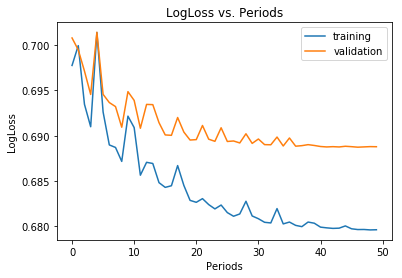

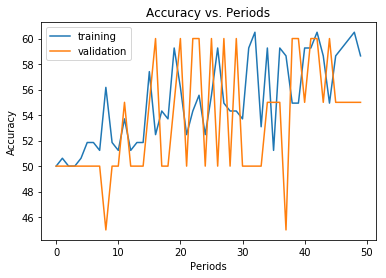

NameError: name 'metrics' is not defined

<Figure size 432x288 with 0 Axes>

In [43]:
print_and_log("Final accuracy (on validation data): {:.4f}%".format(accuracy))

if DISPLAY:
    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(t_lls, label="training")
    plt.plot(v_lls, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "loss.png")

    # Output a graph of accuracy over periods.
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(t_accs, label="training")
    plt.plot(v_accs, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "accuracy.png")
    
#     # Output confusion matrix
#     cm = metrics.confusion_matrix(validation_targets, final_predictions)
#     # Normalize the confusion matrix by row (i.e by the number of samples
#     # in each class).
#     cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
#     ax = sns.heatmap(cm_normalized, cmap="bone_r")
#     ax.set_aspect(1)
#     plt.title("Confusion matrix")
#     plt.ylabel("True label")
#     plt.xlabel("Predicted label")
#     plt.show()

In [ ]:
test_stats = classifier.evaluate(input_fn=test_eval_input_fn)
t_ll = test_stats["loss"]
t_acc = 100 * test_stats["accuracy"]
print_and_log_header("TESTING")
print_and_log("\tLog Loss: {:.2f}".format(t_ll))
print_and_log("\tAccuracy: {:.2f}%".format(t_acc))

###### 